# Shuttle through 10 µm QuBus

Now that the expeimental evidance of long-range shuttling approaches our ultimate goal, it is time to polish previous work.

## Task 1: Simplify the piece-weised pulse
> ### Issue:
> the measurement window of each piece-weised level yields large amount of dataset due to the high sample rate of AWG (i.e. 192/12.5 MHz = 15.36 µs). It is overkilled for loading or reading a single electron tunneling as it is rather slow i.e. in ms range, which as a result generates thousands data points for a tunnel event.

> ### Solutions: 
> From my experience, a time resolution of hundreds µs is sufficient to resolve a single blip due to tunneling. 
> 1. Making simple loading/reading pulse by `TablePT` or `ConstantPT` and let alazar card downsample data as intended.
>> #### Pridictable problems:
>> 1. pulse issue: ConstantPT has inconsistent usage of `Set` and `frozenset` --> Issue: 712. -- DONE
>> 2. atsaverage issue: how should I downsample data with given resolution? How to define mask properly?
>> 3. MATLAB issue: the matlab interface will be buggy for sure. Maybe `conf_seq` has already implemented similar functionalities?
> 2. Making more ineligent pulse as a physist? Just wrapping piece-weised pulses by one more `RepetitionPT` where `measurement_window` can be defined by a given parameter?
>> Other than an un-readable pulse that may potentially make analysis difficult, I don't see any problems by now...

> Others?

Anyway, try to avoid using `PointPT` first.


In [50]:
import sympy
from qupulse.pulses import ConstantPT, RepetitionPT

n_segment, sample_rate, t_res, t_hold = sympy.sympify('n_segment, sample_rate, t_res, t_hold')
t_segment = n_segment / sample_rate
# for HDAWG, n_segment = 192... It is a defined constant MIN_WAVEFORM_LEN = 192 in qupulse.hardware.awg.zihdawg.py

segment = ConstantPT(t_segment, {k : 'v_hold_'+ k for k in 'ABCDEFGH'})

body = RepetitionPT(segment, t_res // t_segment, measurements=[('M', 0, 't_res')],
                    parameter_constraints=['t_res % (n_segment/sample_rate) == 0']) # defines resolutioin
                    
section = RepetitionPT(body, t_hold // t_res,
                       parameter_constraints=['t_hold % t_res == 0']) # defines hold on time at each voltage level

# insepction of parameters:
print(section.parameter_names)

{'n_segment', 'v_hold_G', 'v_hold_F', 't_hold', 'sample_rate', 'v_hold_H', 't_res', 'v_hold_D', 'v_hold_B', 'v_hold_C', 'v_hold_A', 'v_hold_E'}


Now make 3-level square pulse for loading or reading. Maybe extend it to have a user defined section number.

In [51]:
from qupulse.pulses import MappingPT, SequencePT

# but why do I define measurement window by qupulse?
# I know MappingPT can do that, but why necessary?

load = SequencePT(MappingPT(section, parameter_mapping={**{'v_hold_'+k: 'V_load_0'+k for k in 'ABCDEFGH'},
                                                        **{'t_hold': 't_hold_0'}},
                                                        measurement_mapping={'M': 'Load'}),
                  MappingPT(section, parameter_mapping={**{'v_hold_'+k: 'V_load_1'+k for k in 'ABCDEFGH'},
                                                        **{'t_hold': 't_hold_1'}},
                                                        measurement_mapping={'M': 'Load'}),
                  MappingPT(section, parameter_mapping={**{'v_hold_'+k: 'V_load_2'+k for k in 'ABCDEFGH'},
                                                        **{'t_hold': 't_hold_2'}},
                                                        measurement_mapping={'M': 'Load'}))

# inspection:
print(load.parameter_names)
print(load.measurement_names)
print(load._measurement_windows)

{'V_load_0F', 'V_load_1A', 'V_load_0G', 'n_segment', 'V_load_1F', 'V_load_0A', 'V_load_1H', 'V_load_1C', 'V_load_1B', 'sample_rate', 't_hold_0', 't_res', 't_hold_1', 'V_load_1E', 'V_load_2E', 'V_load_0H', 'V_load_0B', 'V_load_2C', 'V_load_0D', 'V_load_2A', 'V_load_1D', 'V_load_2F', 'V_load_2B', 'V_load_2D', 'V_load_0E', 'V_load_2H', 'V_load_1G', 'V_load_2G', 'V_load_0C', 't_hold_2'}
{'Load'}
[]


Does it make sense to assign such a lot parameters individually in a measurement script?

?? Why the measurement window are missing?



In [62]:
channel_tuple = 'ABCDEFGH'
# Assume:   S1, S2, S3, S4, Plunger, S4, SET, Barrier
v_load_0 = [-1.5, 0., 1.5, 0., 0.7, -.2, .3,  0.]
v_load_1 = [-1.5, 0., 1.5, 0., 1.3, -.2, .5,  0.]
v_load_2 = [-1.5, 0., 1.5, 0., 1.3, -.2, .7, -1.]

default_params = {
    **{'V_load_0'+ch: vol for ch, vol in zip(channel_tuple, v_load_0)},
    **{'V_load_1'+ch: vol for ch, vol in zip(channel_tuple, v_load_1)},
    **{'V_load_2'+ch: vol for ch, vol in zip(channel_tuple, v_load_2)},
    't_hold_0': 12,
    't_hold_1': 18,
    't_hold_2': 12,
    't_res': 6,
    'n_segment': 2,
    'sample_rate': 1,
}

print(default_params)
print(load.parameter_names - default_params.keys())
assert not load.parameter_names - default_params.keys()


{'V_load_0A': -1.5, 'V_load_0B': 0.0, 'V_load_0C': 1.5, 'V_load_0D': 0.0, 'V_load_0E': 0.7, 'V_load_0F': -0.2, 'V_load_0G': 0.3, 'V_load_0H': 0.0, 'V_load_1A': -1.5, 'V_load_1B': 0.0, 'V_load_1C': 1.5, 'V_load_1D': 0.0, 'V_load_1E': 1.3, 'V_load_1F': -0.2, 'V_load_1G': 0.5, 'V_load_1H': 0.0, 'V_load_2A': -1.5, 'V_load_2B': 0.0, 'V_load_2C': 1.5, 'V_load_2D': 0.0, 'V_load_2E': 1.3, 'V_load_2F': -0.2, 'V_load_2G': 0.7, 'V_load_2H': -1.0, 't_hold_0': 12, 't_hold_1': 18, 't_hold_2': 12, 't_res': 6, 'n_segment': 2, 'sample_rate': 1}
set()


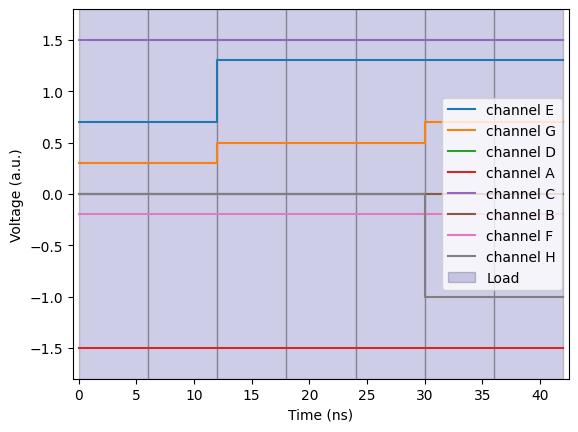

In [63]:
from qupulse.pulses.plotting import plot

_ = plot(load, parameters=default_params, plot_measurements=('Load'))

Yeah! It is for sure an unnecessarily complex pulse for loading an electron.

The reason of complexity is due to the operation 'Downsample' that I'm currently using. It doesn't downsample data points according to any user inputs (basically no input argument is expected) but rather defined by the measurement winodw in the pulse template.

If we have a look at the magin in qupulse to understand how the measurement mask is passed to AtsAverage fristly and then Alazar card:

In [77]:
# qupulse level:
prog = load.create_program(parameters=default_params)
# print(prog)

(begins, lengths), = prog.get_measurement_windows().values()

print(f'Starting time of each window: {begins}')
print(f'Time duration of each window: {lengths}')

Starting time of each window: [ 0.  6. 12. 18. 24. 30. 36.]
Time duration of each window: [6. 6. 6. 6. 6. 6. 6.]


Then the information of measurement windows are handled by special measure in matlab. (unexecutable codes here)   
```MATLAB
% some other scripts...

if isa(operations{k}, 'py.atsaverage._atsaverage_release.ComputeDownsampleDefinition')
    output(k) = util.py.py2mat(size(masks{maskIndex}.length));
elseif isa(operations{k}, 'py.atsaverage._atsaverage_release.ComputeRepAverageDefinition')
    n = util.py.py2mat(masks{maskIndex}.length.to_ndarray);
    if any(n ~= n(1))
        error('daq_operations assumes that all masks should have the same length if using ComputeRepAverageDefinition.');
    end				
    output(k) = n(1);
end
```

At AtsAverage level:
````C++
void ComputeDownsample::processData(const std::vector<Mask>& masks)
{
	results = masks.at(mMask)->getDownsampledData();
}
ats::const_vector_ptr<ResultType> ComputeDownsample::result() const
{
	if (results)
		return results;

	throw AtsAverageRuntimeError("Downsample result not set");
}
````

MATLAB interface

````MATLAB
case 'DS'
    switch mask.type
        case 'Periodic Mask'
            if isfield(mask, 'take') && ~isempty(mask.take)
                smdata.inst(ico(1)).datadim(op_i + NUM_HW_CHANNELS) = mask.take;
            else
                smdata.inst(ico(1)).datadim(op_i + NUM_HW_CHANNELS) = smdata.inst(ico(1)).data.config.total_record_size / mask.period; % 4 is for single point channels
            end
        case 'Auto Mask'
            smdata.inst(ico(1)).datadim(op_i + NUM_HW_CHANNELS) = length(mask.begin); % 4 is for single point channels
        otherwise
            error('Unknown mask: %s',mask.type);
    end
case 'REP AV'
    switch mask.type
        case 'Periodic Mask'
            smdata.inst(ico(1)).datadim(op_i + NUM_HW_CHANNELS) = mask.end-mask.begin;
        case 'Auto Mask'
            smdata.inst(ico(1)).datadim(op_i + NUM_HW_CHANNELS) = mask.length(1);
        otherwise
            error('Unknown mask: %s',mask.type);
    end
````

### Task 2: Tune both sides:
